In [1]:
%load_ext cython
import os
os.environ['XLA_FLAGS'] = '--xla_force_host_platform_device_count=64'
import cbclib as cbc
import numpy as np
import pandas as pd
import pyximport
from importlib import reload
import sys
import hdf5plugin
import h5py
import pygmo
import matplotlib.animation as animation
from tqdm.auto import tqdm
from scipy import ndimage
from scipy.optimize import minimize, differential_evolution
from scipy.interpolate import interpn

import plotly.graph_objects as go
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.widgets import Slider
from pickle import load, dump

pyximport.install(reload_support=True, build_in_temp=False,
                  build_dir='.pyxbld')

(None, <pyximport._pyximport3.PyxImportMetaFinder at 0x2aef6ff1cdc0>)

In [2]:
def generate_lines(Y: int, X: int, n_lines: int, length: float, width: float) -> np.ndarray:
    lengths = length * np.random.rand(n_lines)
    thetas = 2 * np.pi * np.random.rand(n_lines)
    x0, y0 = np.array([[X], [Y]]) * np.random.rand(2, n_lines)
    return np.stack((x0 - 0.5 * lengths * np.cos(thetas),
                      y0 - 0.5 * lengths * np.sin(thetas),
                      x0 + 0.5 * lengths * np.cos(thetas),
                      y0 + 0.5 * lengths * np.sin(thetas),
                      width * np.ones(n_lines)), axis=1)

In [3]:
lines = generate_lines(50, 50, 1, 30, 2)

In [6]:
%time out = cbc.src.draw_line_image(lines, (50, 50), kernel='triangular')
%time out2 = cbc.bin.draw_line_image((50, 50), lines, profile='linear')

CPU times: user 680 µs, sys: 0 ns, total: 680 µs
Wall time: 619 µs
CPU times: user 569 µs, sys: 0 ns, total: 569 µs
Wall time: 483 µs


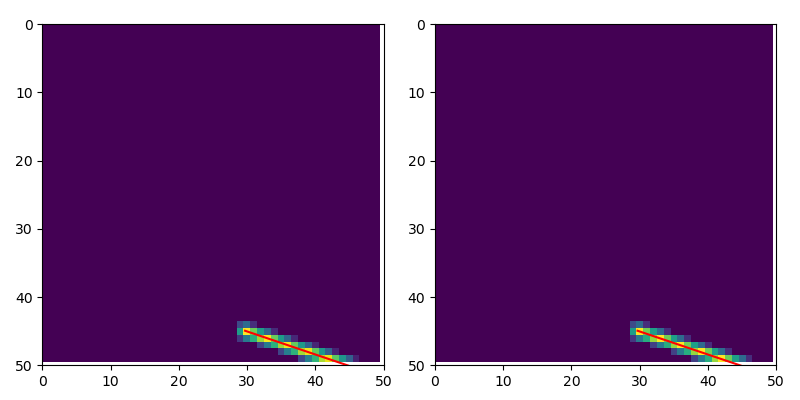

In [7]:
%matplotlib widget
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
# ax.imshow(cbc.bin.draw_line_image((500, 500), lines))
axes[0].imshow(out)
axes[1].imshow(out2)

for line in lines:
    axes[0].plot(line[:4:2], line[1:4:2], c='r')
    axes[1].plot(line[:4:2], line[1:4:2], c='r')

for ax in axes:
    ax.set_xlim(0, 50)
    ax.set_ylim(50, 0)

fig.tight_layout()
plt.show()

In [2]:
frames = np.load('results/frames.npz')['data']

pts = (100, 100, 102, 102)

line2 = cbc.src.test_line(pts, frames[0], 2, 2)
print(line2)

[94.14390495940982, 98.70175180237152, 94.88103593353188, 104.85308483384154]


In [3]:
from scripts.cbsd_numpy import add_line, generate_line, Image, Structure

struct = Structure.new(2, 2)
image = Image.new(frames[0], struct)
line = generate_line(pts[0], pts[1], image, struct.idxs)
line = add_line(line, generate_line(pts[2], pts[3], image, struct.idxs)).update_bounds(image)
print(line.bounds)

LineBounds(x0=94.14390536223841, y0=98.70175205903284, x1=94.88103665990128, y1=104.85308511749105)


In [2]:
if sys.modules.get('dev'): # Maybe sys.modules is better?
    dev = sys.modules.get('dev')
    dev = reload(dev)
else:
    import dev
print(dir(dev))

['__builtins__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', '__test__', 'det_to_k', 'det_to_k_vjp', 'k_to_det', 'k_to_det_vjp', 'k_to_smp', 'k_to_smp_vjp', 'np', 'source_lines', 'source_lines_vjp']


In [3]:
cbc.src.test_tree(10, 10.0)

Points generated:
{62.79, 0.457071} {52.732, 52.0583} {48.9691, 72.1126} {57.6175, 26.2205} {44.2573, 35.6995} {26.6319, 70.1085} {24.1097, 98.7394} {94.012, 72.9012} {42.578, 38.4482} {41.6519, 41.2914} 
Points in the tree:
{42.578, 38.4482} {41.6519, 41.2914} {24.1097, 98.7394} {26.6319, 70.1085} {44.2573, 35.6995} {57.6175, 26.2205} {62.79, 0.457071} {52.732, 52.0583} {48.9691, 72.1126} {94.012, 72.9012} 
Inserting {65.978, 71.1129}
{65.978, 71.1129} inserted
inserted == end() after inserting twice
Tree:
		(42.578, 38.4482) axis = 0
	(41.6519, 41.2914) axis = 1
		(24.1097, 98.7394) axis = 0
			(26.6319, 70.1085) axis = 1
(44.2573, 35.6995) axis = 0
		(57.6175, 26.2205) axis = 0
			(62.79, 0.457071) axis = 1
	(52.732, 52.0583) axis = 1
		(48.9691, 72.1126) axis = 0
				(65.978, 71.1129) axis = 0
			(94.012, 72.9012) axis = 1
low  : [24.1097, 0.457071]
high : [94.012, 98.7394]
{65.978, 71.1129} found
erase returned {94.012, 72.9012}
Tree:
		(42.578, 38.4482) axis = 0
	(41.6519, 41.291

In [4]:
inp = np.random.randint(0, 100, 400).reshape((20, 20))
%time peaks = cbc.src.local_maxima(inp, axis=(0, 1), num_threads=1)

CPU times: user 253 µs, sys: 1.21 ms, total: 1.47 ms
Wall time: 949 µs


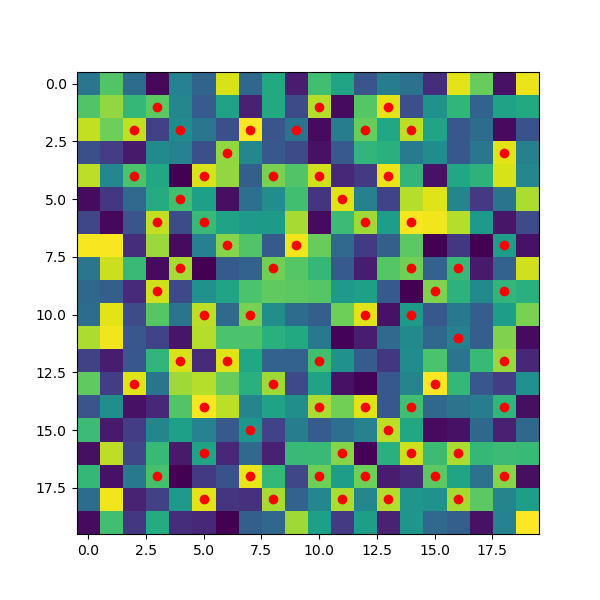

In [5]:
%matplotlib widget
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(inp)
ax.scatter(peaks[:, 1], peaks[:, 0], c='r')
plt.show()

In [16]:
n_samples, ndim, sigma = 100, 3, 5.0
y = 10 * np.random.rand(n_samples)
x = 100 * np.random.rand(n_samples, ndim)
x_hat = 100 * np.random.rand(50, ndim)

%time out = cbc.src.kr_predict(y, x, x_hat, sigma)
%time out2 = cbc.bin.kr_predict(y, x, x_hat, sigma)

CPU times: user 1.07 ms, sys: 31 µs, total: 1.1 ms
Wall time: 749 µs
CPU times: user 1.51 ms, sys: 39 µs, total: 1.54 ms
Wall time: 1.1 ms


In [17]:
np.isclose(out, out2)

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True])

In [13]:
shape = (10, 20, 30)
grid = tuple(np.arange(length) for length in np.array(shape)[::-1])
coords = np.random.rand(500, 3)
for i in range(len(shape)):
    coords[:, i] *= shape[len(shape) - 1 - i]
data = np.random.rand(*shape)

%time out = cbc.src.binterpolate(data, grid, coords)
%time out2 = cbc.bin.binterpolate(data, grid, coords)

CPU times: user 1.01 ms, sys: 40 µs, total: 1.05 ms
Wall time: 477 µs
CPU times: user 392 µs, sys: 0 ns, total: 392 µs
Wall time: 244 µs


In [14]:
np.all(np.isclose(out, out2, 1e-3, 1e-3))

True

In [ ]:
gauss = cbc.src.gaussian_kernel(sigma=10.0, order=1)
gauss2 = cbc.bin.gaussian_kernel(sigma=10.0, order=1)

In [ ]:
%matplotlib widget
fig, ax = plt.subplots(figsize=(6, 3))
ax.plot(gauss)
ax.plot(gauss2)
fig.tight_layout()
plt.show()

In [ ]:
lines = np.tile(np.array([0.0, 0.0, 1.0, 1.0, 20.0]), (100, 100, 1))
lines[..., [0, 2]] += np.random.randint(0, 500, (1, 100, 1))
lines[..., [1, 3]] += np.random.randint(0, 500, (1, 100, 1))
lines = list(lines)

In [ ]:
%time out = cbc.src.draw_line_table(lines[0], (500, 500), profile='quad', num_threads=1)
%time out2 = cbc.bin.draw_line_table(lines[0], (500, 500), profile='quad')

In [ ]:
frame = np.zeros((500, 500))
np.add.at(frame, (out[1], out[0]), out[2])

In [ ]:
frame = frame

%matplotlib widget
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(frame, vmin=0, vmax=1)
for line in lines[0]:
    ax.plot(line[:4:2], line[1:4:2], c='r')
ax.set_ylim(frame.shape[0], 0)
ax.set_xlim(0, frame.shape[1])
fig.tight_layout()
plt.show()

In [ ]:
from typing import Tuple

idxs = np.arange(-6, 6)
size = (0, 5)

def mirror(inp: np.ndarray, size: Tuple[int]):
    inp = inp - size[0]
    clip = size[1] - size[0] - 1
    quotient = (inp // clip) % 2
    return quotient * clip + (1 - 2 * quotient) * (inp % clip) + size[0]

def reflect(inp: np.ndarray, size: Tuple[int]):
    inp = inp - size[0]
    clip = size[1] - size[0]
    quotient = (inp // (clip)) % 2
    return quotient * (clip - 1) + (1 - 2 * quotient) * (inp % (clip)) + size[0]

def wrap(inp: np.ndarray, size: Tuple[int]):
    inp = inp - size[0]
    clip = size[1] - size[0]
    return (inp % clip) + size[0]

print(reflect(idxs, size))
print(mirror(idxs, size))
print(wrap(idxs, size))

In [ ]:
arr = np.random.rand(3, 3)

In [ ]:
from scipy.ndimage import median_filter

mode, size = 'wrap', (10, 10)
 
%time out = cbc.src.median_filter(arr, size=size, mode=mode)
%time out2 = cbc.bin.median_filter(arr, size=size, mode=mode)
%time out3 = median_filter(arr, size=size, mode=mode)

print(out == out3)

In [ ]:
arr = np.random.rand(100, 100, 100)

In [ ]:
axis = -1
 
%time out = cbc.src.median(arr, axis=axis)
%time out2 = cbc.bin.median(arr, axis=axis)
%time out3 = np.median(arr, axis=axis)

print(np.isclose(out, out2))

In [ ]:
arr = np.ones((10, 10))
kernel = np.random.rand(5)

%time out = cbc.src.fft_convolve(arr, kernel, axis=-1)
%time out2 = cbc.bin.fft_convolve(arr, kernel, axis=-1)

np.isclose(out, out2)

In [ ]:
arr = np.random.rand(10, 20)

%time out = cbc.src.gaussian_filter(arr, sigma=1.0)
%time out2 = cbc.bin.gaussian_filter(arr, sigma=1.0)

np.isclose(out, out2)

In [ ]:
arr = np.random.randint(0, 100000, size=(100, 100))

%time out2 = np.array([cbc.bin.next_fast_len(target, backend='fftw') for target in arr.ravel()]).reshape(arr.shape)
%time out = cbc.src.next_fast_len(arr)

out == out2

In [ ]:
basis = np.array([[-0.00093604, -0.00893389, -0.00049815],
                  [0.00688718, -0.00039195, -0.00573877],
                  [0.01180108, -0.00199115,  0.01430421]])
kmin = np.array([0.00876745, 0.00437237, 0.99995201])
kmax = np.array([0.03538482, 0.03246592, 0.99884627])
hkl = np.array([[ -8,  18,   5],
                [ 24,   4,   1],
                [  6, -12,  -5],
                [ -4,  -2,  -1],
                [ 17,  15,   5],
                [-19,  -3,  -3],
                [  0,  -7,  -3],
                [ 24,  -6,  -3],
                [ 16,  20,   6],
                [ -1,   9,   3]])
hkl = np.tile(hkl, (10, 1))

%time kin = dev.source_lines(hkl=hkl, basis=basis.ravel(), kmin=kmin, kmax=kmax)[0]
%time kin2 = cbc.src.source_lines(hkl=hkl, basis=basis, kmin=kmin[:2], kmax=kmax[:2])[0]

np.isclose(np.sort(kin, axis=1), np.sort(kin2, axis=1))

In [ ]:
crop = cbc.Crop(roi=(1100, 3260, 1040, 3108))
setup = cbc.ScanSetup.import_ini('results/Lysozyme_June_2021/exp_geom_232_ref_2.ini')

scan_num = 232
dir_path = '/asap3/petra3/gpfs/p11/2021/data/11010570/raw'
h5_dir = os.path.join(dir_path, f'scan_frames/Scan_{scan_num:d}')
h5_files = sorted([os.path.join(h5_dir, path) for path in os.listdir(h5_dir)
                   if path.endswith(('LambdaFar.nxs', '.h5'))])
data = cbc.CrystData(cbc.CXIStore(h5_files), transform=crop)

wf_data = cbc.CrystData(cbc.CXIStore(f'results/Lysozyme_June_2021/scan_250_whitefield.h5'),
                        transform=crop).load('whitefield')

In [ ]:
idxs = np.arange(0, 300, 5)

data = data.clear().load(idxs=idxs)

In [ ]:
x0, y0 = crop.forward_points(x=setup.pupil_roi[2], y=setup.pupil_roi[0])
x1, y1 = crop.forward_points(x=setup.pupil_roi[3], y=setup.pupil_roi[1])
pad = 40
roi = (int(y0) - pad, int(y1) + pad, int(x0) - pad, int(x1) + pad)

In [ ]:
frames = np.arange(data.shape[0])
%time wf = cbc.bin.robust_mean(inp=data.data[frames] * data.mask[frames], \
                               axis=0, r0=0.0, r1=0.5, n_iter=12, lm=9.0, \
                               num_threads=data.num_threads)
%time wf2 = cbc.src.robust_mean(inp=data.data[frames], mask=data.mask[frames], \
                                axis=0, r0=0.0, r1=0.5, n_iter=12, lm=9.0, \
                                num_threads=data.num_threads)

In [ ]:
W = wf
std = np.sqrt(wf)
y = np.where(std, data.data / std, 0.0)
W = np.where(std, W / std, 0.0)

%time x = cbc.bin.robust_lsq(W=W, y=y, axis=(1, 2), r0=0.0, r1=0.5, n_iter=12, lm=9.0, \
                             num_threads=data.num_threads)
%time x2 = cbc.src.robust_lsq(W=W, y=y, mask=data.mask, axis=(1, 2), \
                              r0=0.0, r1=0.5, n_iter=12, lm=9.0, \
                              num_threads=data.num_threads)

print(x)
print(x2)